# Reduced space

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import torch
from sympy.utilities.iterables import multiset_permutations
import pickle

import time
tStart_notebook = time.time()

import sys
sys.path.insert(0, '../source')

import opinf as opinf
from source.SnapshotTransformer import SnapshotTransformerExtension as SnapshotTransformer

import source.helpers_polyMat as polyMat

## user settings

In [2]:
training_time = 2
scaling = "maxnorm"
slicer = 1
nRB_max = 8

## training data

In [3]:
with open('data/fom_1e-3', 'rb') as handle:
    [U, grid_t, final_time] = pickle.load(handle)

In [4]:
dt = grid_t[1]
K_train = int(training_time / dt)

U_train = U[:, :K_train+1]
final_training_time = grid_t[K_train]

In [5]:
U_train_cut = U_train[:, ::slicer]

## rescaling

In [6]:
# rescaling
transformer = None
if scaling is not None:
    
    # transformer = opinf.pre.SnapshotTransformer(center = False, scaling = scaling, verbose = True)
    transformer = SnapshotTransformer(center = False, scaling = scaling, verbose = True)
    
    U_transformed = transformer.fit_transform(U_train_cut.copy())
    U_original = U_train.copy()
    U_train_cut = U_transformed
    U_train = transformer.transform(U_train)
    #U_train_list = [transformer.transform(u) for u in U_train_list]

here
here
Learned maxnorm scaling Q -> Q''
    |     min    |    mean    |     max    |    std
----|------------|------------|------------|------------
Q   |  7.887e-01 |  1.578e+00 |  2.471e+00 |  5.084e-01
Q'' |  2.086e-02 |  4.174e-02 |  6.537e-02 |  1.345e-02



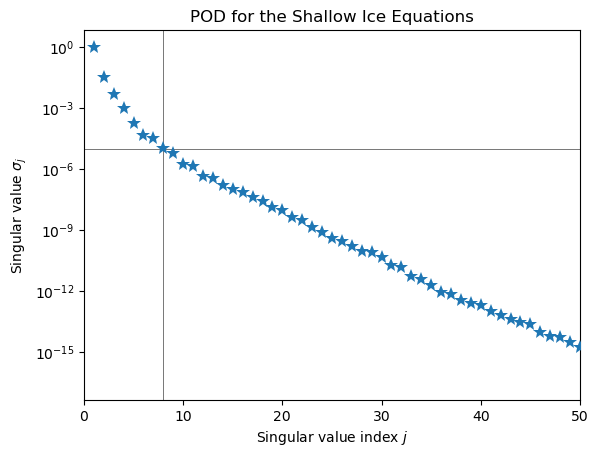

In [7]:
fig, ax = plt.subplots(1,1)

# reduced space
VR, svdvals = opinf.pre.pod_basis(U_train_cut) # POD basis
nRB = opinf.pre.svdval_decay(svdvals, 1e-5, plot=True, ax=ax)  # select basis dimension
WR = VR[:, :nRB] 
VR = VR[:, :nRB]

ax.set_xlim(0, 50)
ax.set_title("POD for the Shallow Ice Equations")

plt.savefig("pod_slicer{}_closeup.png".format(slicer))

In [8]:
# with open('data/RB_slicer{}'.format(slicer), 'wb') as handle:
#     pickle.dump([transformer, U_train_cut, VR, nRB, slicer], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
__, sigma, __ = la.svd(U_train_cut)
singular_values = np.array(svdvals) / sum(svdvals)
tol = [1e-5]
ranks = [np.count_nonzero(singular_values > epsilon) for epsilon in tol]

In [10]:
svdvals2 = np.sort(sigma)[::-1]**2
res_energy = 1 - (np.cumsum(svdvals2) / np.sum(svdvals2))
cum_energy = np.cumsum(svdvals2) / np.sum(svdvals2)

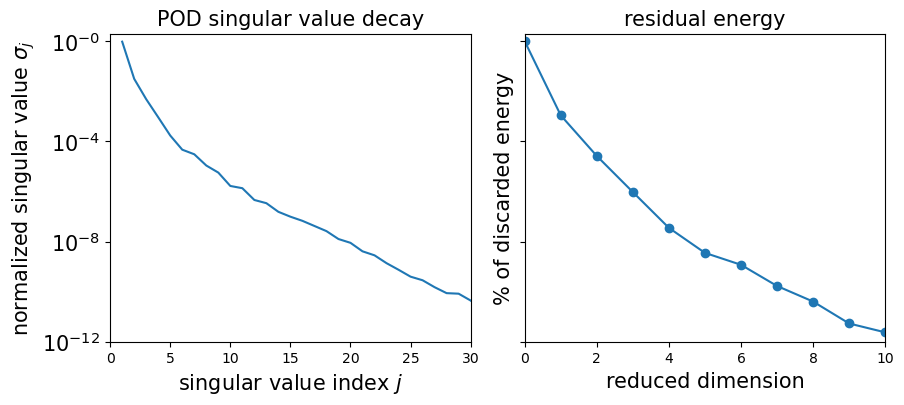

In [11]:
fig, axs = plt.subplots(1,2, sharey = True, figsize = (10, 4))
fsize = 15

j = np.arange(1, singular_values.size + 1)
axs[0].semilogy(j, singular_values, ms=10, mew=0, zorder=3)
axs[0].set_xlim((0, j.size))
ylim = ax.get_ylim()

axs[0].set_ylim(ylim)
axs[0].set_xlabel(r"singular value index $j$", fontsize=fsize)
axs[0].set_ylabel(r"normalized singular value $\sigma_j$", fontsize=fsize)

axs[0].set_xlim(0, 30)
axs[0].set_title("POD singular value decay", fontsize=fsize)


j = np.arange(0, singular_values.size + 1)
axs[1].semilogy(j, np.hstack([1, res_energy]), marker = "o")
axs[1].set_xlim(0, j.size)

axs[1].set_xlabel(r"reduced dimension", fontsize=fsize)
axs[1].set_ylabel(r"% of discarded energy", fontsize=fsize)


axs[1].set_xlim(0, 10)
axs[1].set_title("residual energy", fontsize=fsize)

axs[0].set_ylim(1e-12, 2)
axs[0].set_yticks([1e-12, 1e-8, 1e-4, 1e-0], ["$10^{-12}$", "$10^{-8}$", "$10^{-4}$", "$10^{-0}$"], fontsize=fsize)

fig.subplots_adjust(wspace = 0.15)
fig.savefig("plots/reduced-space.png", bbox_inches="tight")

## The End.

In [12]:
print("Runtime of this notebook: {} min".format((time.time()-tStart_notebook)/60))

Runtime of this notebook: 0.024320177237192788 min
